# Fine-tuning a Pretrained Network for Style Recognition

In this example, we'll explore a common approach that is particularly useful in real-world applications: take a pre-trained Caffe network and fine-tune the parameters on your custom data.

The upside of such approach is that, since pre-trained networks are learned on a large set of images, the intermediate layers capture the "semantics" of the general visual appearance. Think of it as a very powerful feature that you can treat as a black box. On top of that, only a few layers will be needed to obtain a very good performance of the data.

First, we will need to prepare the data. This involves the following parts:
(1) Get the ImageNet ilsvrc pretrained model with the provided shell scripts.
(2) Download a subset of the overall Flickr style dataset for this demo.
(3) Compile the downloaded Flickr dataset into a database that Caffe can then consume.

In [1]:
import os
os.chdir('..')
import sys
sys.path.insert(0, './python')

import caffe
import numpy as np
from pylab import *
%matplotlib inline

In [2]:
# This downloads the ilsvrc auxiliary data (mean file, etc),
# and a subset of 2000 images for the style recognition task.
!data/ilsvrc12/get_ilsvrc_aux.sh
!scripts/download_model_binary.py models/bvlc_reference_caffenet
!python examples/finetune_flickr_style/assemble_data.py \
    --workers=-1 --images=2000 --seed=1701 --label=5

Downloading...
--2016-10-09 23:20:46--  http://dl.caffe.berkeleyvision.org/caffe_ilsvrc12.tar.gz
Resolving dl.caffe.berkeleyvision.org (dl.caffe.berkeleyvision.org)... 169.229.222.251
Connecting to dl.caffe.berkeleyvision.org (dl.caffe.berkeleyvision.org)|169.229.222.251|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17858008 (17M) [application/octet-stream]
Saving to: ‘caffe_ilsvrc12.tar.gz’

100%[======================================>] 17,858,008  81.1MB/s   in 0.2s   

2016-10-09 23:20:46 (81.1 MB/s) - ‘caffe_ilsvrc12.tar.gz’ saved [17858008/17858008]

Unzipping...
Done.
Model already exists.
Writing train/val for 1992 successfully downloaded images.


Let's show what is the difference between the fine-tuning network and the original caffe model.

In [3]:
!diff models/bvlc_reference_caffenet/train_val.prototxt models/finetune_flickr_style/train_val.prototxt

1c1
< name: "CaffeNet"
---
> name: "FlickrStyleCaffeNet"
4c4
<   type: "Data"
---
>   type: "ImageData"
15,26c15,19
< # mean pixel / channel-wise mean instead of mean image
< #  transform_param {
< #    crop_size: 227
< #    mean_value: 104
< #    mean_value: 117
< #    mean_value: 123
< #    mirror: true
< #  }
<   data_param {
<     source: "examples/imagenet/ilsvrc12_train_lmdb"
<     batch_size: 256
<     backend: LMDB
---
>   image_data_param {
>     source: "data/flickr_style/train.txt"
>     batch_size: 50
>     new_height: 256
>     new_width: 256
31c24
<   type: "Data"
---
>   type: "ImageData"
42,51c35,36
< # mean pixel / channel-wise mean instead of mean image
< #  transform_param {
< #    crop_size: 227
< #    mean_value: 104
< #    mean_value: 117
< #    mean_value: 123
< #    mirror: false
< #  }
<   data_param {
<     source: "examples/imagenet/ilsvrc12_val_lmdb"
---
>   image_data_param {
>     source: "data/flickr_style/test.txt"
53c38,39
<     backend: LMDB
---
>     

For your record, if you want to train the network in pure C++ tools, here is the command:

<code>
build/tools/caffe train \
    -solver models/finetune_flickr_style/solver.prototxt \
    -weights models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel \
    -gpu 0
</code>

However, we will train using Python in this example.

In [4]:
niter = 200
# losses will also be stored in the log
train_loss = np.zeros(niter)
scratch_train_loss = np.zeros(niter)

caffe.set_device(0)
caffe.set_mode_gpu()
# We create a solver that fine-tunes from a previously trained network.
solver = caffe.SGDSolver('models/finetune_flickr_style/solver.prototxt')
solver.net.copy_from('models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel')
# For reference, we also create a solver that does no finetuning.
scratch_solver = caffe.SGDSolver('models/finetune_flickr_style/solver.prototxt')

# We run the solver for niter times, and record the training loss.
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    scratch_solver.step(1)
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    scratch_train_loss[it] = scratch_solver.net.blobs['loss'].data
    if it % 10 == 0:
        print 'iter %d, finetune_loss=%f, scratch_loss=%f' % (it, train_loss[it], scratch_train_loss[it])
print 'done'

iter 0, finetune_loss=3.405821, scratch_loss=3.179682
iter 10, finetune_loss=2.722270, scratch_loss=9.002842
iter 20, finetune_loss=1.886347, scratch_loss=2.406911
iter 30, finetune_loss=1.776482, scratch_loss=1.920538
iter 40, finetune_loss=2.430863, scratch_loss=2.057495
iter 50, finetune_loss=1.900755, scratch_loss=1.934857
iter 60, finetune_loss=1.184684, scratch_loss=1.937282
iter 70, finetune_loss=1.121261, scratch_loss=1.787812
iter 80, finetune_loss=1.288304, scratch_loss=1.658677
iter 90, finetune_loss=1.262951, scratch_loss=1.771544
iter 100, finetune_loss=1.035389, scratch_loss=1.730677
iter 110, finetune_loss=1.203973, scratch_loss=1.697273
iter 120, finetune_loss=1.151863, scratch_loss=1.652318
iter 130, finetune_loss=1.126860, scratch_loss=1.686098
iter 140, finetune_loss=1.061152, scratch_loss=1.755636
iter 150, finetune_loss=1.252853, scratch_loss=1.651802
iter 160, finetune_loss=0.907392, scratch_loss=1.729657
iter 170, finetune_loss=1.177128, scratch_loss=1.799015
ite

Let's look at the training loss produced by the two training procedures respectively.

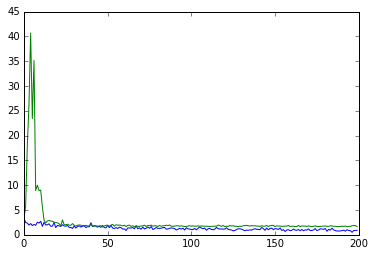

In [5]:
plot(np.vstack([train_loss, scratch_train_loss]).T)

Notice how the fine-tuning procedure produces a more smooth loss function change, and ends up at a better loss. A closer look at small values, clipping to avoid showing too large loss during training:

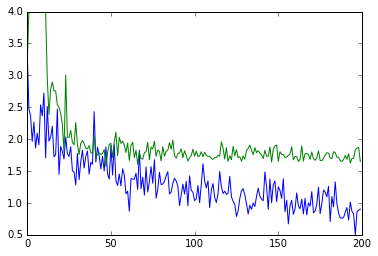

In [6]:
plot(np.vstack([train_loss, scratch_train_loss]).clip(0, 4).T)

Let's take a look at the testing accuracy after running 200 iterations. Note that we are running a classification task of 5 classes, thus a chance accuracy is 20%. As we will reasonably expect, the finetuning result will be much better than the one from training from scratch. Let's see.

In [7]:
test_iters = 10
accuracy = 0
scratch_accuracy = 0
for it in arange(test_iters):
    solver.test_nets[0].forward()
    accuracy += solver.test_nets[0].blobs['accuracy'].data
    scratch_solver.test_nets[0].forward()
    scratch_accuracy += scratch_solver.test_nets[0].blobs['accuracy'].data
accuracy /= test_iters
scratch_accuracy /= test_iters
print 'Accuracy for fine-tuning:', accuracy
print 'Accuracy for training from scratch:', scratch_accuracy

Accuracy for fine-tuning: 0.563999998569
Accuracy for training from scratch: 0.220000001788


Huzzah! So we did finetuning and it is awesome. Let's take a look at what kind of results we are able to get with a longer, more complete run of the style recognition dataset. Note: the below URL might be occassionally down because it is run on a research machine.

http://demo.vislab.berkeleyvision.org/